In [1]:
from IPython.display import display
from IPython.display import Image
from utils import * # Code shared across more than one notebook

**Main contributors:** F. P. Vidal and J. M. Létang

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to images generated with the state-of-the-art Monte Caro simulation packages. An anthropomorphic phantom is used. It corresponds to a 5-year old boy. We take into account i) a realistic beam spectrum (tube voltage and filtration) and ii) the energy response of the detector.

**Material and Methods:** We simulate an image with gVirtualXRay and compare it with a ground truth image. For this purpose, we use [Gate](http://www.opengatecollaboration.org/), a wrapper for CERN's state-of-the-art Monte Caro simulation tool: [Geant4](https://geant4.web.cern.ch/). The number of tracked particles is 1e9.

In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is polychromatic. The voltage is 85 kV. The filtration is 0.1 mm of copper and 1 mm of aluminium. The energy response of the detector is considered. It mimics a 600-micron thick CsI scintillator.

In [2]:
Image(filename="pediatric_phantom_data/pediatric-setup.png")

The sample is made of a 70x70x15mm box of water, in which 5 columns of 3 spheres of different radii (2, 3.5, and 5mm) have been inserted. A given material is associated to the spheres of each column (bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue). The columns are ordered in decreasing density. We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).

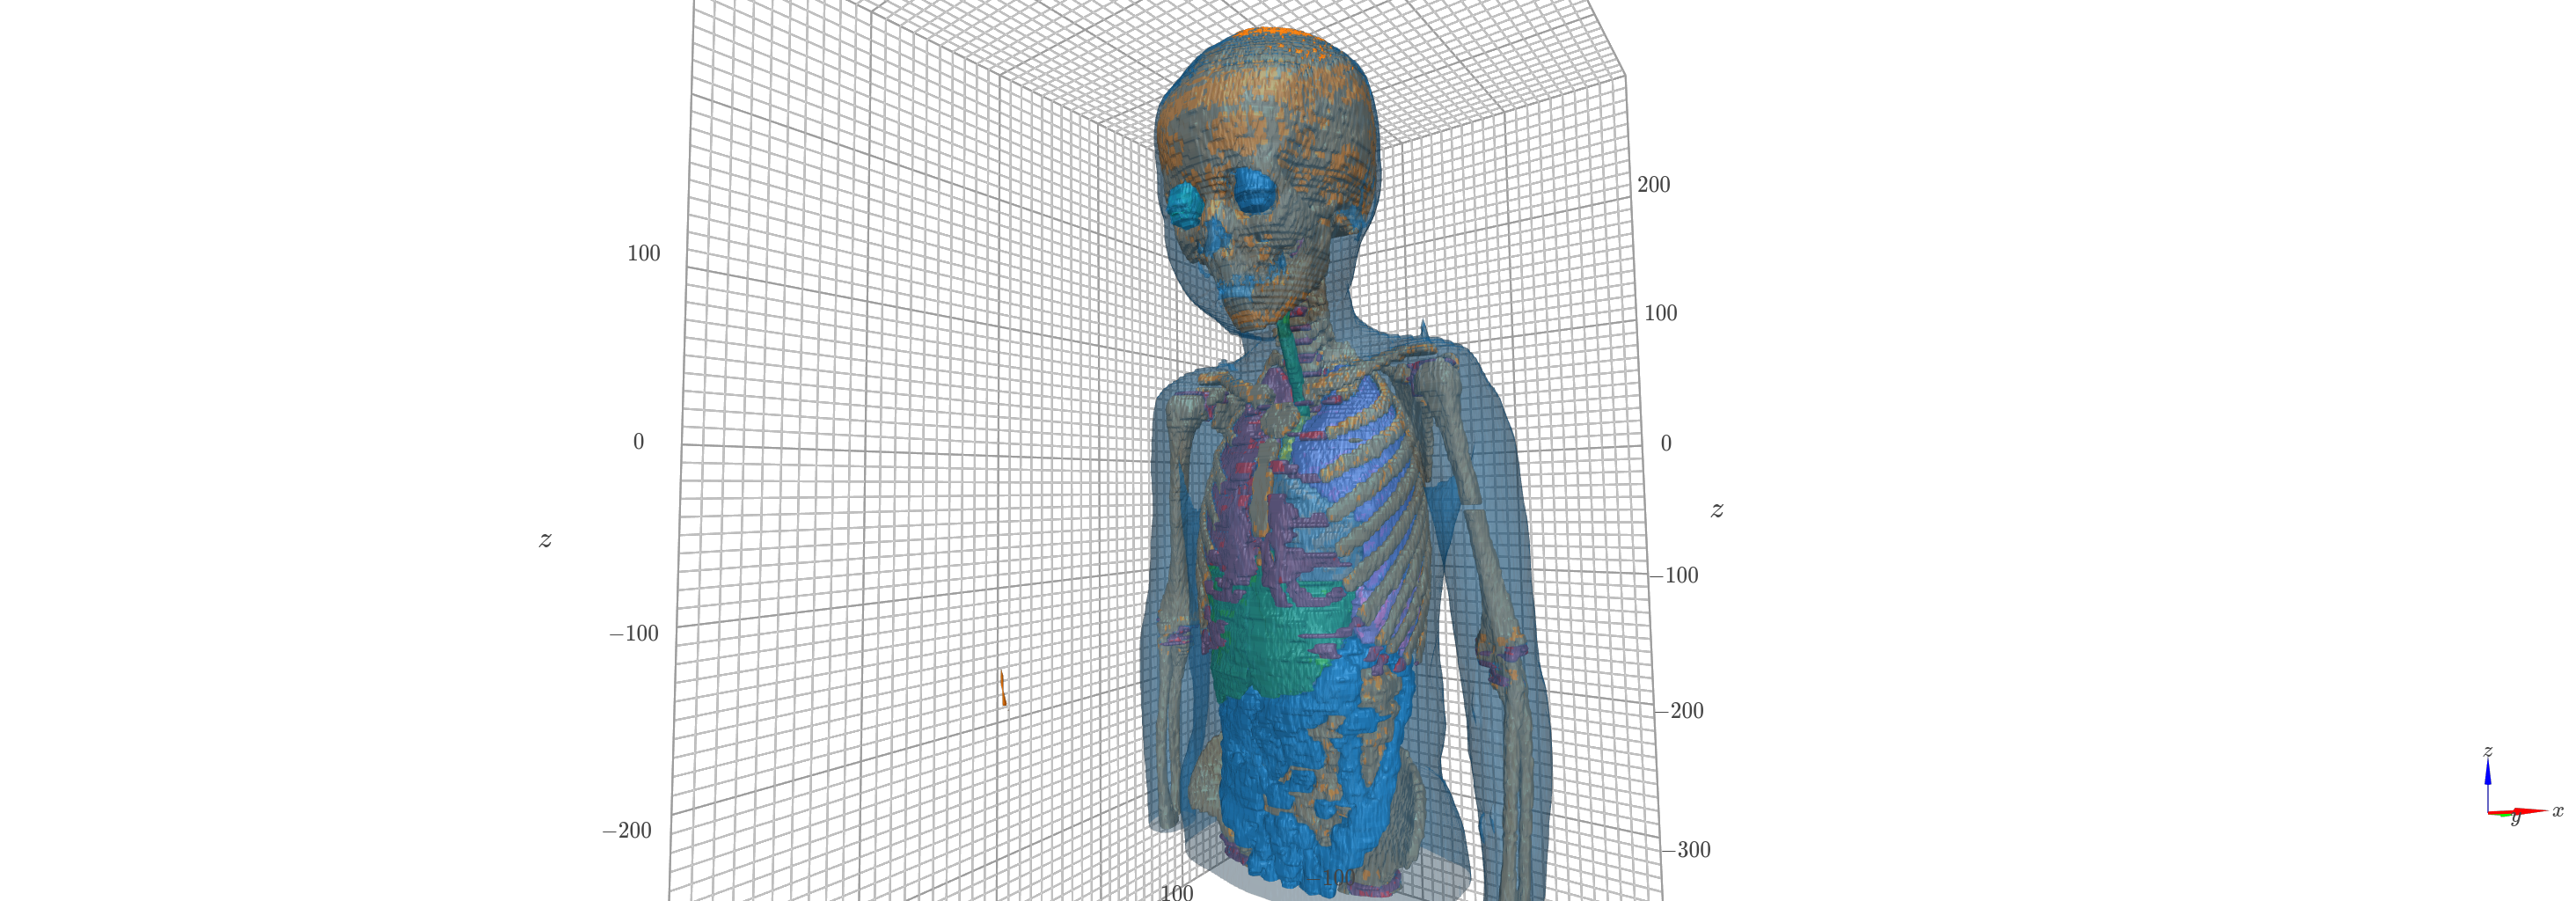

In [3]:
Image(filename="plots/pediatric_model.png", width=800)

**Results:** The calculations were performed on the following platform:

In [4]:
printSystemInfo()

OS:
	Linux 5.14.21-150400.22-default
	x86_64

CPU:
 	Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz

RAM:
	31 GB
GPU:
	Name: NVIDIA GeForce RTX 2080 Ti
	Drivers: 515.48.07
	Video memory: 11 GB


The Monte Carlo simulation needed 5.36e6 HS06 seconds to complete. 

It is equivalent to **8.68E+08** ms (i.e. ~10 days) on the system used. Only $161 \pm 6$ ms was needed with the GPU used.

The [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), between the two simulated images is **MAPE 1.85%**. The **[zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is 99.99%**. 
The **[Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is 0.99**. 

As MAPE is relatively low (less than 2%), SSIM is high (close to 1), and ZNCC is high (close to 100%), we can conclude that this X-ray image simulated with gVirtualXRay on GPU in milliseconds is comparable to the same Monte Carlo simulation that ran for days.

# Import packages

In [5]:
%matplotlib inline

import os # Locate files

import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import urllib, zipfile

import matplotlib

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
# matplotlib.rc('text', usetex=True)

from scipy.stats import pearsonr # Compute the correlatio coefficient

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize # Resample the images

from tifffile import imread, imwrite # Load/Write TIFF files

import datetime # For the runtime

import k3d, base64
import SimpleITK as sitk
from stl import mesh
import random
from sitk2vtk import sitk2vtk

from gvxrPython3 import gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up
from utils import * # Code shared across more than one notebook

SimpleGVXR 1.1.7 (2022-06-30T14:42:37) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.7 (2022-06-30T14:42:37) [Compiler: GNU g++] on Linux


# Reference image

We first load the reference image that has been simulated using [Gate](http://www.opengatecollaboration.org/) wrapper for CERN's [Geant4](https://geant4.web.cern.ch/). Here we ignore scattering.

In [6]:
Image = imread("pediatric_phantom_data/direct.tif")
Full_field = np.ones(Image.shape) # Perfect full field image
Dark_field = np.zeros(Full_field.shape) # Perfect dark field image

Projections are then corrected to account for variations in beam homogeneity and in the pixel-to-pixel sensitivity of the detector. This is the projection with flat-field correction ($\mathbf{Proj}$):
\begin{equation}
\mathbf{Proj} = \frac{\boldsymbol{I} - \boldsymbol{D}}{\boldsymbol{F} - \boldsymbol{D}}
\label{eq:flat-fields}
\end{equation}
where $\boldsymbol{F}$ (full fields) and $\boldsymbol{D}$ (dark fields) are projection images without sample and acquired with and without the X-ray beam turned on respectively. 
<!-- Note that with an ideal detector ($\boldsymbol{R}_i=E_i$), pixels of $\boldsymbol{D}$ are null, and pixels of $\boldsymbol{F}$ are equal to $\sum_i E_i \; \boldsymbol{N}_i$. 
 -->

We now apply the flat-field correction to `Image`.

In [7]:
gate_image = (Image - Dark_field) / (Full_field - Dark_field)
# gate_image = Image / np.mean(Full_field)

We plot the image using a linear look-up table and a power-law normalisation.

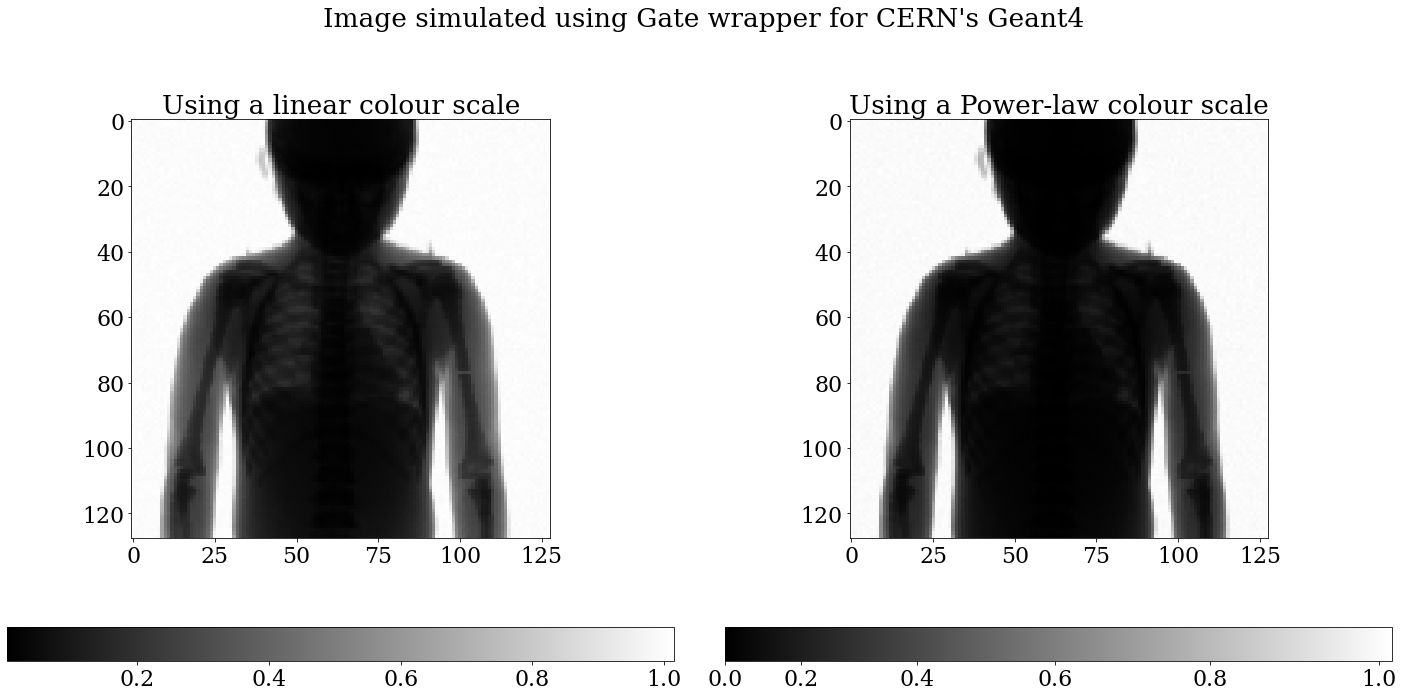

In [8]:
displayLinearPowerScales(gate_image,
                         "Image simulated using Gate wrapper for CERN's Geant4",
                         "plots/reference_from_Gate-paediatrics")

# Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [9]:
json2gvxr.initGVXR("notebook-6.json", "OPENGL")

Create an OpenGL context: 800x450


0

NVIDIA Corporation
NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
3.2.0 NVIDIA 515.48.07



## X-ray source

We create an X-ray source. It is a point source.

In [10]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0.0, 1000.0, 0.0, 'mm']
	Source shape: PointSource


## Spectrum

The spectrum is polychromatic.

In [11]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=0)
energy_set = sorted(spectrum.keys())

count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])

Plot the spectrum

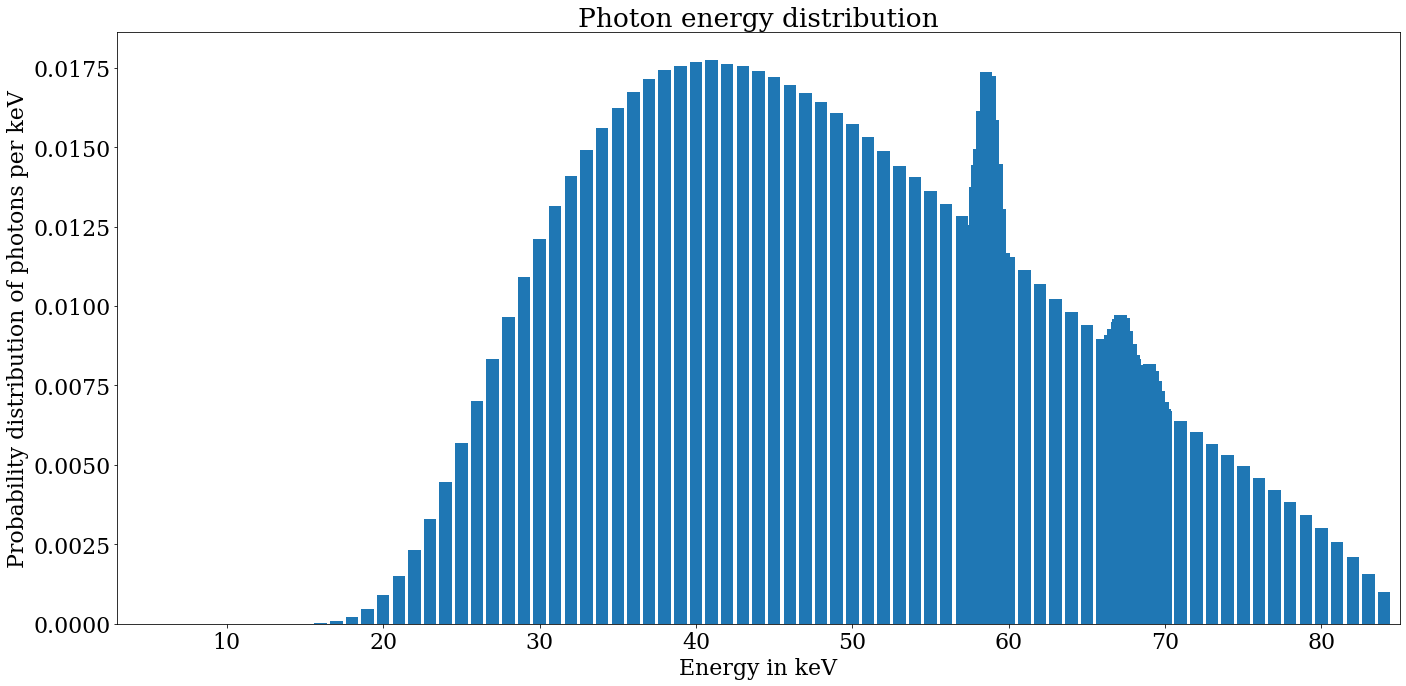

In [12]:
k *= 1000
plotSpectrum(k, f, "plots/spectrum-paediatrics", xlim=[np.min(k), np.max(k)])

## Detector

Create a digital detector

In [13]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0.0, -150.0, 0.0, 'mm']
	Detector up vector: [0, 0, -1]
	Detector number of pixels: [1024, 1024]
	Energy response: Gate_data/responseDetector.txt in MeV
	Pixel spacing: [0.48828125, 0.48828125, 'mm']


## Model the energy response of the detector

Load the energy response

In [14]:
detector_response = np.loadtxt("Gate_data/responseDetector.txt")

Display the energy response

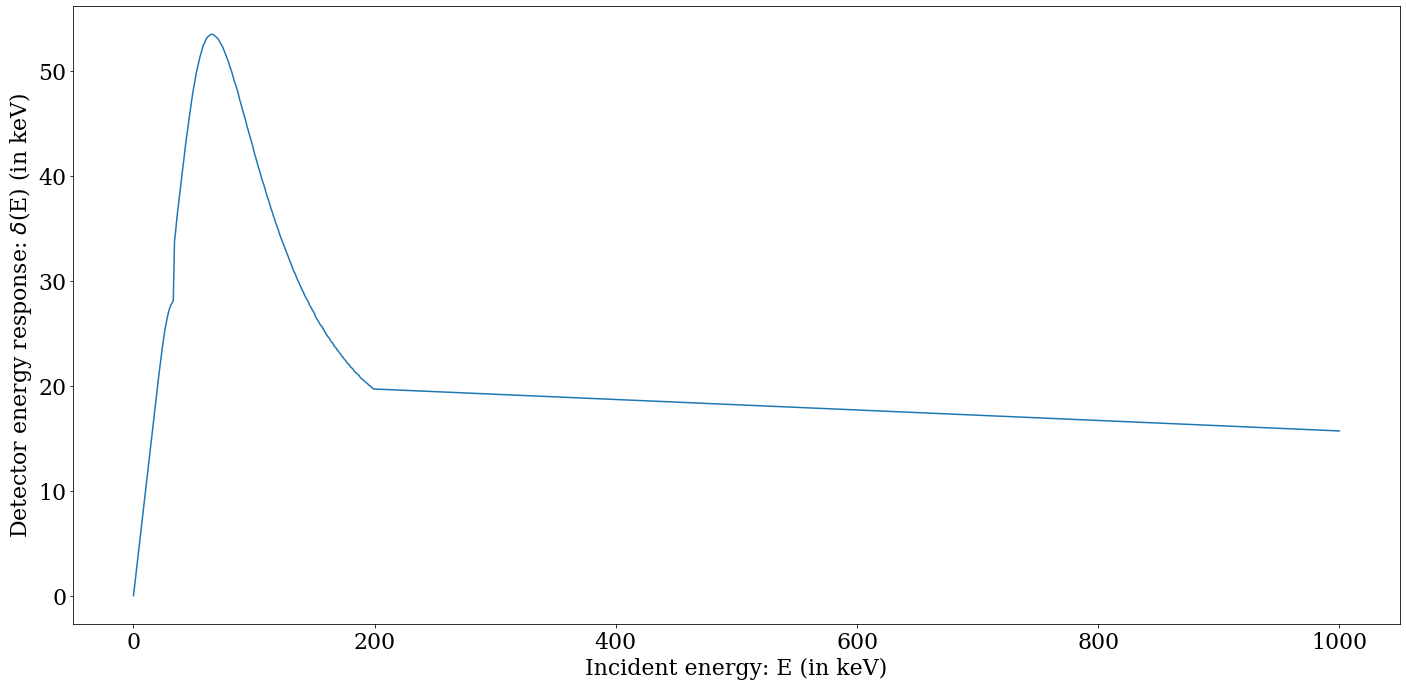

In [15]:
plt.figure(figsize= (20,10))
# plt.title("Detector response")
plt.plot(detector_response[:,0] * 1000, detector_response[:,1] * 1000)
plt.xlabel('Incident energy: E (in keV)')
plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')

plt.tight_layout()

plt.savefig('plots/detector_response.pdf')
plt.savefig('plots/detector_response.png')

## Converting the voxelised phantom to surface meshes

Download and unzip the phantom

In [16]:
if not os.path.exists("pediatric_phantom_data/Pediatric phantom.zip"):
    urllib.request.urlretrieve("https://drive.uca.fr/f/384a08b5f73244cf9ead/?dl=1", "pediatric_phantom_data/Pediatric phantom.zip")

    with zipfile.ZipFile("pediatric_phantom_data/Pediatric phantom.zip","r") as zip_ref:
        zip_ref.extractall("pediatric_phantom_data")

Load the phantom

In [17]:
phantom = sitk.ReadImage("pediatric_phantom_data/Pediatric phantom/Pediatric_model.mhd")

Thu Jun 30 16:01:24 2022 ---- Create window Thu Jun 30 16:01:24 2022 ---- Create windowThu Jun 30 16:01:24 2022 ---- OpenGL vendor:Thu Jun 30 16:01:24 2022 ---- OpenGL renderer:Thu Jun 30 16:01:24 2022 ---- OpenGL version:Thu Jun 30 16:01:24 2022 ---- Use OpenGL 4.5.Thu Jun 30 16:01:25 2022 ---- Initialise the renderer

Load the labels

In [18]:
df = pd.read_csv("pediatric_phantom_data/labels.dat")

Process every structure of the phantom

In [19]:
if not os.path.exists("pediatric_phantom_data/meshes"):
    os.mkdir("pediatric_phantom_data/meshes")

meshes = []

for threshold, organ in zip(df["Label"], df["Organs"]):

    # Ignore air
    if organ != "Air":

        print("Process", organ)
        
        mesh_fname = "pediatric_phantom_data/meshes/" + organ + ".stl"
        meshes.append(mesh_fname)

        # Only create the mesh if it does not exist
        if not os.path.exists(mesh_fname):
            
            # Threshold the phantom
            binary_image = (phantom == threshold)

            # Smooth the binary segmentation
            smoothed_binary_image = sitk.AntiAliasBinary(binary_image)
                            
            # Create a VTK image
            vtkimg = sitk2vtk(smoothed_binary_image, centre=True)

            vtk_mesh = extractSurface(vtkimg, 0)
            
#             print('Before decimation')
#             print(f'There are {mesh.GetNumberOfPoints()} points.')
#             print(f'There are {mesh.GetNumberOfPolys()} polygons.')

#             decimate = vtk.vtkDecimatePro()
#             decimate.SetInputData(mesh)
#             decimate.SplittingOn()
#             decimate.SetTargetReduction(30)
#             decimate.PreserveTopologyOn()
#             decimate.Update()

#             decimated = vtk.vtkPolyData()
#             decimated.ShallowCopy(decimate.GetOutput())

#             print('After decimation')
#             print(f'There are {decimated.GetNumberOfPoints()} points.')
#             print(f'There are {decimated.GetNumberOfPolys()} polygons.')
#             print(
#                 f'Reduction: {(mesh.GetNumberOfPolys() - decimated.GetNumberOfPolys()) / mesh.GetNumberOfPolys()}')
            
#             print("\n\n")
#             writeSTL(decimated, mesh_fname)
            writeSTL(vtk_mesh, mesh_fname)

Process Muscle
Process Bone
Process Stomach-Interior
Process Cartilage
Process Brain
Process Bladder
Process Gallbladder
Process Heart
Process Kidneys-right
Process Kidneys-left
Process Small-Intestine
Process Large-Intestine
Process Liver
Process Lung-right
Process Lung-left
Process Pancreas
Process Spleen
Process Stomach
Process Thymus
Process Eyes-right
Process Eyes-left
Process Skull
Process Trachea


Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [20]:
json2gvxr.initSamples(verbose=0)

pediatric_phantom_data/meshes/Muscle.stl	nb_faces:	1756726	nb_vertices:	5270178	bounding_box (in cm):	(-17.9687, -10.8887, -30.9017)	(16.6016, 11.1799, 28.6986)
pediatric_phantom_data/meshes/Bone.stl	nb_faces:	541826	nb_vertices:	1625478	bounding_box (in cm):	(-16.7969, -23.6577, -30.9017)	(15.2152, 9.88865, 16.3501)
pediatric_phantom_data/meshes/Stomach-Interior.stl	nb_faces:	9452	nb_vertices:	28356	bounding_box (in cm):	(-1.34334, -2.38867, -17.0041)	(4.16143, 3.05231, -8.50205)
pediatric_phantom_data/meshes/Cartilage.stl	nb_faces:	163322	nb_vertices:	489966	bounding_box (in cm):	(-16.7615, -4.32288, -30.9017)	(15.5041, 8.717, 16.6771)
pediatric_phantom_data/meshes/Brain.stl	nb_faces:	124028	nb_vertices:	372084	bounding_box (in cm):	(-7.32082, -9.98695, 16.3501)	(7.50031, 5.78681, 28.1222)
pediatric_phantom_data/meshes/Bladder.stl	nb_faces:	3712	nb_vertices:	11136	bounding_box (in cm):	(-3.78536, 2.11808, -30.9017)	(0.175804, 5.49461, -29.7572)
pediatric_phantom_data/meshes/Gallbladd

Visualise the phantom

In [21]:
plot = k3d.plot()
plot.background_color = 0xffffff

for sample in json2gvxr.params["Samples"]:
    
    label = sample["Label"]
    
    fname = sample["Path"]

    r, g, b, a = gvxr.getAmbientColour(label)
    R = math.floor(255*r)
    G = math.floor(255*g)
    B = math.floor(255*b)
    A = math.floor(255*a)

    k3d_color = 0;
    k3d_color |= (R & 255) << 16;
    k3d_color |= (G & 255) << 8;
    k3d_color |= (B & 255);

    mesh_from_stl_file = mesh.Mesh.from_file(fname)

    if label == "Muscle":
        opacity = 0.4
    else:
        opacity = 1
    geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
                          range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
                          color=k3d_color, 
                          wireframe=False, 
                          flat_shading=False,
                          name=fname,
                          opacity=opacity)

    plot += geometry   

plot.display()
plot.camera = [321.6678075002728,   -461.4855245196105, -34.86613985320561,
                 0,                    0,                -1.635009765625,
                 0.08017827340927154, -0.083269170696295, 0.9932963755519574]

Output()

In [22]:
fname = 'plots/pediatric_model.png'
if not os.path.isfile(fname):

    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    plot.fetch_screenshot()

    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)

# Run the simulation

Update the 3D visualisation and take a screenshot

In [23]:
gvxr.displayScene()

gvxr.computeXRayImage()
gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(1549.6787109375)

angle = math.pi / 2.0
rotation_matrix_x = np.array([ 1, 0, 0, 0,
                               0, math.cos(angle), -math.sin(angle), 0,
                               0, math.sin(angle),  math.cos(angle), 0,
                               0, 0, 0, 1])

rotation_matrix_z = np.array([ math.cos(angle), -math.sin(angle), 0, 0,
                               math.sin(angle),  math.cos(angle), 0, 0,
                               0, 0, 1, 0,
                               0, 0, 0, 1])

rotation_matrix_x.shape = [4,4]
rotation_matrix_z.shape = [4,4]

transformation_matrix = np.identity(4)

transformation_matrix = np.matmul(rotation_matrix_x, transformation_matrix)
transformation_matrix = np.matmul(rotation_matrix_z, transformation_matrix)

gvxr.setSceneRotationMatrix(transformation_matrix.flatten())

gvxr.setWindowBackGroundColour(1, 1, 1)

gvxr.displayScene()

In [24]:
screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

In [25]:
fname = 'pediatric_phantom_data/screenshot.png'
if not os.path.isfile(fname):

    plt.imsave(fname, screenshot)

In [26]:
gvxr.setZoom(1549.6787109375)
gvxr.setSceneRotationMatrix([-0.19267332553863525, -0.06089369207620621, 0.9793692827224731,  0.0,
                              0.9809651970863342,  -0.03645244985818863, 0.19072122871875763, 0.0,
                              0.02408679760992527,  0.9974713325500488,  0.06675821542739868, 0.0, 
                              0.0,                  0.0,                 0.0,                 1.0])

gvxr.setWindowBackGroundColour(0.5, 0.5, 0.5)

gvxr.useNegative()

gvxr.displayScene()

In [27]:
screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

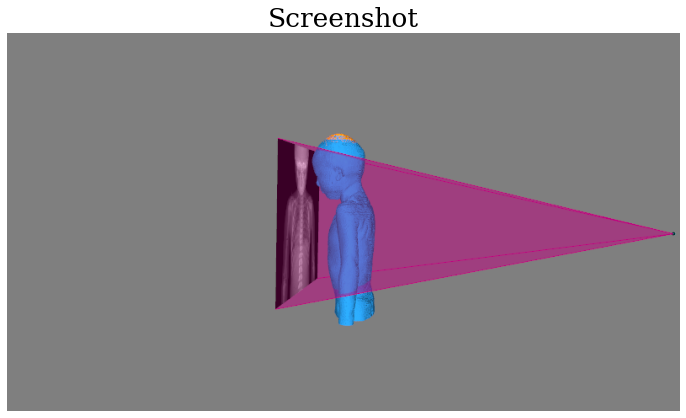

In [28]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-on-paediatrics.pdf')
plt.savefig('plots/screenshot-beam-on-paediatrics.png')

Compute an X-ray image 50 times (to gather performance statistics)

In [29]:
# gvxr.enableArtefactFilteringOnCPU()
gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering() # Spere inserts are missing with GPU integration when a outer surface is used for the matrix


runtimes = []

for i in range(50):
    start_time = datetime.datetime.now()
    gvxr.computeXRayImage()
    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes.append(delta_time.total_seconds() * 1000)

Save an X-ray image

In [30]:
# Compute the L-buffers on the GPU and integrate on the GPU
x_ray_image_integration_GPU = np.array(gvxr.computeXRayImage())
x_ray_image_integration_GPU = resize(x_ray_image_integration_GPU, gate_image.shape)
imwrite('gVirtualXRay_output_data/projection_raw_integration_GPU_paediatrics.tif', x_ray_image_integration_GPU.astype(np.single))

Flat-field correction

In [31]:
total_energy_in_keV = 0.0
for energy, count in zip(energy_set, count_set):
    total_energy_in_keV += energy * count
    
total_energy_in_MeV = gvxr.getTotalEnergyWithDetectorResponse()

In [32]:
white = np.ones(x_ray_image_integration_GPU.shape) * total_energy_in_MeV
dark = np.zeros(x_ray_image_integration_GPU.shape)

x_ray_image_integration_GPU = (x_ray_image_integration_GPU - dark) / (white - dark)

Save the corresponding image

In [33]:
imwrite('gVirtualXRay_output_data/projection_corrected_integration_GPU_paediatrics.tif', x_ray_image_integration_GPU.astype(np.single))

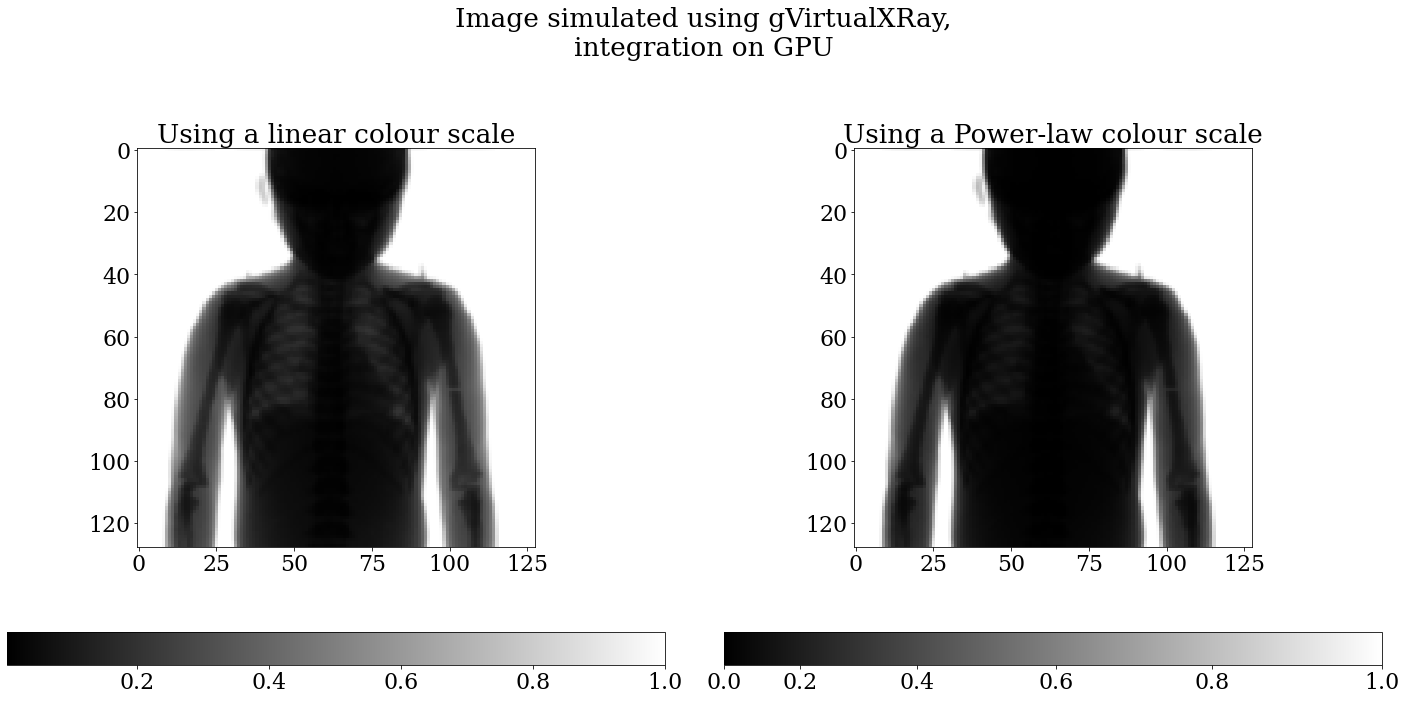

In [34]:
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated using gVirtualXRay,\nintegration on GPU", y=1.02)

plt.subplot(121)
plt.imshow(x_ray_image_integration_GPU, cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(x_ray_image_integration_GPU, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/x_ray_image_integration_GPU-paediatrics.pdf')
plt.savefig('plots/x_ray_image_integration_GPU-paediatrics.png')

# Comparison the analytic simulation with the Monte Carlo simulation

## Quantitative validation

Compute image metrics between the two simulated images:

1. [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD),
2. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
3. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


We use these three metrics as one is a disimilarity measurement (MAPE), two are similarity measurement (ZNCC & SSIM). MAPE and ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of MAPE s 0%; of ZNCC 100%, and SSIM 1.

In [35]:
# Avoid div by 0
offset1 = min(gate_image.min(), x_ray_image_integration_GPU.min())
offset2 = 0.01 * (gate_image.max() - gate_image.min())
offset = offset2 - offset1

MAPE_integration_GPU = mape(gate_image + offset, x_ray_image_integration_GPU + offset)

# MAPE_integration_GPU = mape(gate_image, x_ray_image_integration_GPU)
ZNCC_integration_GPU = np.mean((gate_image - gate_image.mean()) / gate_image.std() * (x_ray_image_integration_GPU - x_ray_image_integration_GPU.mean()) / x_ray_image_integration_GPU.std())
SSIM_integration_GPU = ssim(gate_image, x_ray_image_integration_GPU, data_range=gate_image.max() - gate_image.min())

print("MAPE_integration_GPU:", "{0:0.2f}".format(100 * MAPE_integration_GPU) + "%")
print("ZNCC_integration_GPU:", "{0:0.2f}".format(100 * ZNCC_integration_GPU) + "%")
print("SSIM_integration_GPU:", "{0:0.2f}".format(SSIM_integration_GPU))

MAPE_integration_GPU: 1.85%
ZNCC_integration_GPU: 99.99%
SSIM_integration_GPU: 0.99


Get the total number of triangles

In [36]:
number_of_triangles = 0

for mesh in json2gvxr.params["Samples"]:
    label = mesh["Label"]
    number_of_triangles += gvxr.getNumberOfPrimitives(label)

In [37]:
runtime_avg = round(np.mean(runtimes))
runtime_std = round(np.std(runtimes))

Print a row of the table for the paper

In [38]:
print("Paediatric -- polychromatic (85 kV), detector energy response & Gate & " + 
      "{0:0.2f}".format(100 * MAPE_integration_GPU) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_integration_GPU) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_integration_GPU) + "    &    $" +
      str(json2gvxr.params["Detector"]["NumberOfPixels"][0]) + " \\pm " + str(json2gvxr.params["Detector"]["NumberOfPixels"][1]) + "$    &    " +
      str(number_of_triangles) + "    &    " +
      "8.68E+08    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

Paediatric -- polychromatic (85 kV), detector energy response & Gate & 1.85\%    &    99.99\%    &    0.99    &    $1024 \pm 1024$    &    3552778    &    8.68E+08    &    $161 \pm 6$ \\


In both cases, MAPE is very small (less than 2%), ZNCC is very high (almost 100%), and SSIM is very high (almost 1). We can conclude that the two images are similar. The main difference lie in the Poisson noise affecting the Monte Carlo simulation.

## Qualitative validation

Checkboard comparison

In [39]:
font = {'size'   : 12.5
       }
matplotlib.rc('font', **font)

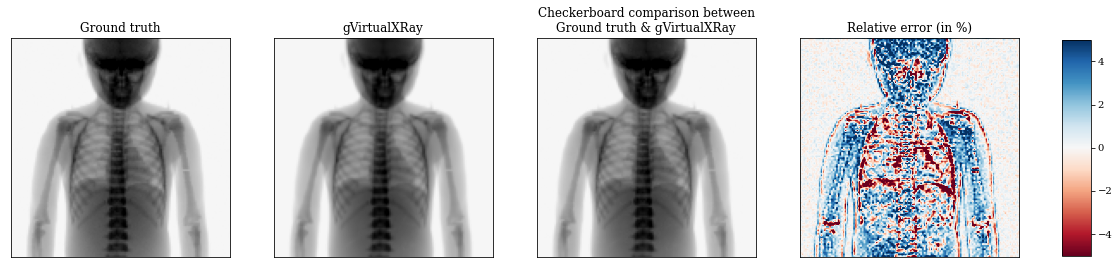

In [40]:
%matplotlib inline
fullCompareImages(gate_image,
                  x_ray_image_integration_GPU,
                  "gVirtualXRay\n with integration on GPU",
                  "plots/full_comparison_integration_GPU-paediatrics", log=True,
                 avoid_div_0=True)

Plot the profiles

In [41]:
font = {'size'   : 12.5
       }
matplotlib.rc('font', **font)

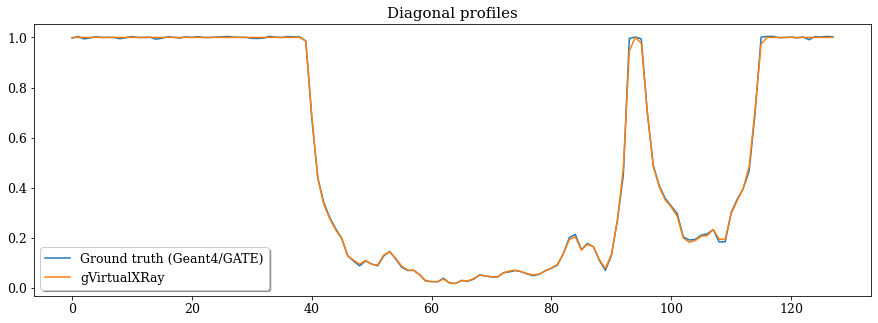

In [42]:
ground_truth_diag = np.diag(gate_image)
gvxr_diag = np.diag(x_ray_image_integration_GPU)

plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles")

ax.plot(ground_truth_diag, label="Ground truth (Geant4/GATE)")
ax.plot(gvxr_diag, label="gVirtualXRay")

ax.legend(loc='best',
          ncol=1, fancybox=True, shadow=True)

plt.savefig('plots/profiles-paediatrics.pdf')
plt.savefig('plots/profiles-paediatrics.png')

# All done

Destroy the window

In [43]:
gvxr.destroyAllWindows()


0(0x56083d60d250)
